# Overview
- Quan Hoang Ngoc
- ID: 22521178

In [1]:
print("oke")
import torch
print(torch.__version__)
print(torch.cuda.is_available())

oke
2.5.1+cu121
True


In [2]:
!pip install umap-learn
!pip install kagglehub
!pip install missingno

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

# Visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# from pywaffle import Waffle

%matplotlib inline
init_notebook_mode(connected= True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             auc,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)

# Dimensionality reduction
from sklearn.decomposition import PCA
from umap import UMAP
import pylab as pl

# Imbalance dataset handling
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler,
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)

from imblearn.over_sampling import (SMOTE,
                                    ADASYN)

# Model algorithms
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Case study

- **Goal**: Visualize the relationships between various Healthy and Unhealthy habits to Heart Strokes, and there by predict the stroke probability with best model and hypertuned parameters.

- **Questions and Assumptions**:
1. Does age has impact on strokes? and How is this parameter distributed?
2. Does body mass index and glucose levels in a person, propel a heart stroke?
3. Assumption: Smoking can induce Stroke, is it true?
4. Assumption: Heart with a Heart Disease is prone to Stroke, is it true?
5. Assumption: Workload results in high blood pressure and that could lead to Stroke, is it true?
6. Assumption: Males are most susceptible to strokes due to high work related stress, is it true?
7. Relationship between continous and categorical data
8. Feature importance and Feature Selection for accurate predictions  

- All the assumptions are made from following articles and trying to address these points with data in this notebook

* [ Is It a Stroke or a Heart Attack?](https://www.healthline.com/health/stroke-vs-heart-attack)
* [ Heart Disease and Stroke](https://www.webmd.com/heart-disease/stroke)
* [ What is stroke?](https://www.heartandstroke.ca/stroke/what-is-stroke)
* [ Stroke after a heart attack: What’s the risk?](https://www.health.harvard.edu/heart-health/stroke-after-a-heart-attack-whats-the-risk)

- **Data**:
- In this section, loading of data, visulaizing missing values and feature extraction will be carried out.
- In the current dataset, there are 11 features and one binary target. A brief information about the features are given below
1. **id**: Identification number of the individual.
2. **gender**: Gender of the individual.
3. **hypertension**: Health related parameter, does person have hypertension.
4. **heart_disease**: Health related parameter, does person have heart disease.
5. **ever_married**: Personal information, is person married on not?
6. **work_type**: Nature of work place.
7. **Residence_type**: Residence type of the individual.
8. **avg_glucose_level**: average glucose level in blood for the individual.
9. **bmi**: body mass index of the individual.
10. **smoking_status**: Habitual information. Current smoking status of individual.
11. **stroke**: Our taget, is person suffered heart attack?

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

# print("Path to dataset files:", path)

# import shutil
# import os

# # Assuming 'path' contains the path to the downloaded dataset from kagglehub
# data_folder = 'data'  # Create a 'data' folder if it doesn't exist
# os.makedirs(data_folder, exist_ok=True)

# # Copy the downloaded dataset to the 'data' folder
# shutil.copytree(path, os.path.join(data_folder, 'stroke-prediction-dataset'))

# print(f"Dataset copied to: {os.path.join(data_folder, 'stroke-prediction-dataset')}")

# Data Loading

In [ ]:
df = pd.read_csv('train.csv')
### Drop id and other
df = df.drop(columns=["id"])
df = df.drop(df[df["gender"] == "Other"].index)
df = df.reset_index(drop=True)
### Compute types
dtypes = ['bool', 'int64', 'float64']
cat_cols = df.select_dtypes(exclude=dtypes).columns
num_cols = df.select_dtypes(include=dtypes).columns

#** Normalize df
def reformat(df):
    ### Format object string
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.columns = df.columns.str.lower().str.replace('-', '_')
    for col in df.select_dtypes(exclude=dtypes).columns:
        df[col] = df[col].astype('object')
        df[col] = df[col].str.lower()
        df[col] = df[col].str.replace(' ', '_')
        df[col] = df[col].str.replace('-', '_')
        df[col] = df[col].replace({'yes': 1, 'no': 0})
        df[col] = df[col].replace({'true': 1, 'false': 0})

    for col in df.select_dtypes(include=dtypes).columns:
        df[col] = df[col].astype('float64')

    ### Drop rows duplicate
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)

    ### Sort columns
    # Get column names and their corresponding data types
    col_names = df.columns.str.lower()
    column_dtypes = df.dtypes
    # Sort columns based on data type and column names
    sorted_columns = sorted(
        col_names,  # Assume col_names is a list of column names
        key=lambda col: (column_dtypes[col].name, col)  # Sort by dtype and then name
    )
    # Move 'stroke' column to the end if it exists
    if 'stroke' in sorted_columns:
        sorted_columns.append(sorted_columns.pop(sorted_columns.index('stroke')))
    df = df[sorted_columns]

    global cat_cols, num_cols
    cat_cols, num_cols = [], []
    for col in df.columns:
        if(len(df[col].unique()) < 10): cat_cols.append(col)
        else: num_cols.append(col)
    return df

df = reformat(df)
print(cat_cols, num_cols, df.shape, sep="\n")
df.head(10).T

['ever_married', 'heart_disease', 'hypertension', 'gender', 'residence_type', 'smoking_status', 'work_type', 'stroke']
['age', 'avg_glucose_level', 'bmi']
(15303, 11)


,0,1,2,3,4,5,6,7,8,9
age,28.0,33.0,42.0,56.0,24.0,34.0,53.0,78.0,45.0,62.0
avg_glucose_level,79.53,78.44,103.0,64.87,73.36,84.35,88.97,75.32,107.22,62.68
bmi,31.1,23.9,40.3,28.8,28.8,22.2,25.3,24.8,34.1,18.4
ever_married,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
hypertension,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gender,male,male,female,male,female,female,female,male,female,female
residence_type,urban,rural,rural,urban,rural,urban,rural,rural,rural,urban
smoking_status,never_smoked,formerly_smoked,unknown,never_smoked,never_smoked,unknown,never_smoked,unknown,never_smoked,formerly_smoked
work_type,private,private,private,private,private,private,private,self_employed,private,govt_job


In [6]:
df.info()
round(df.describe().T, 2), round(df.describe(exclude='float').T, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15303 entries, 0 to 15302
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                15303 non-null  float64
 1   avg_glucose_level  15303 non-null  float64
 2   bmi                15303 non-null  float64
 3   ever_married       15303 non-null  float64
 4   heart_disease      15303 non-null  float64
 5   hypertension       15303 non-null  float64
 6   gender             15303 non-null  object 
 7   residence_type     15303 non-null  object 
 8   smoking_status     15303 non-null  object 
 9   work_type          15303 non-null  object 
 10  stroke             15303 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


(                     count   mean    std    min   25%    50%    75%    max
 age                15303.0  41.42  21.44   0.08  26.0  43.00  57.00   82.0
 avg_glucose_level  15303.0  89.04  25.48  55.22  74.9  85.12  96.98  267.6
 bmi                15303.0  28.11   6.72  10.30  23.5  27.60  32.00   80.1
 ever_married       15303.0   0.68   0.47   0.00   0.0   1.00   1.00    1.0
 heart_disease      15303.0   0.02   0.15   0.00   0.0   0.00   0.00    1.0
 hypertension       15303.0   0.05   0.22   0.00   0.0   0.00   0.00    1.0
 stroke             15303.0   0.04   0.20   0.00   0.0   0.00   0.00    1.0,
                 count unique           top  freq
 gender          15303      2        female  9446
 residence_type  15303      2         rural  7663
 smoking_status  15303      4  never_smoked  6281
 work_type       15303      5       private  9752)

## Valid distribution

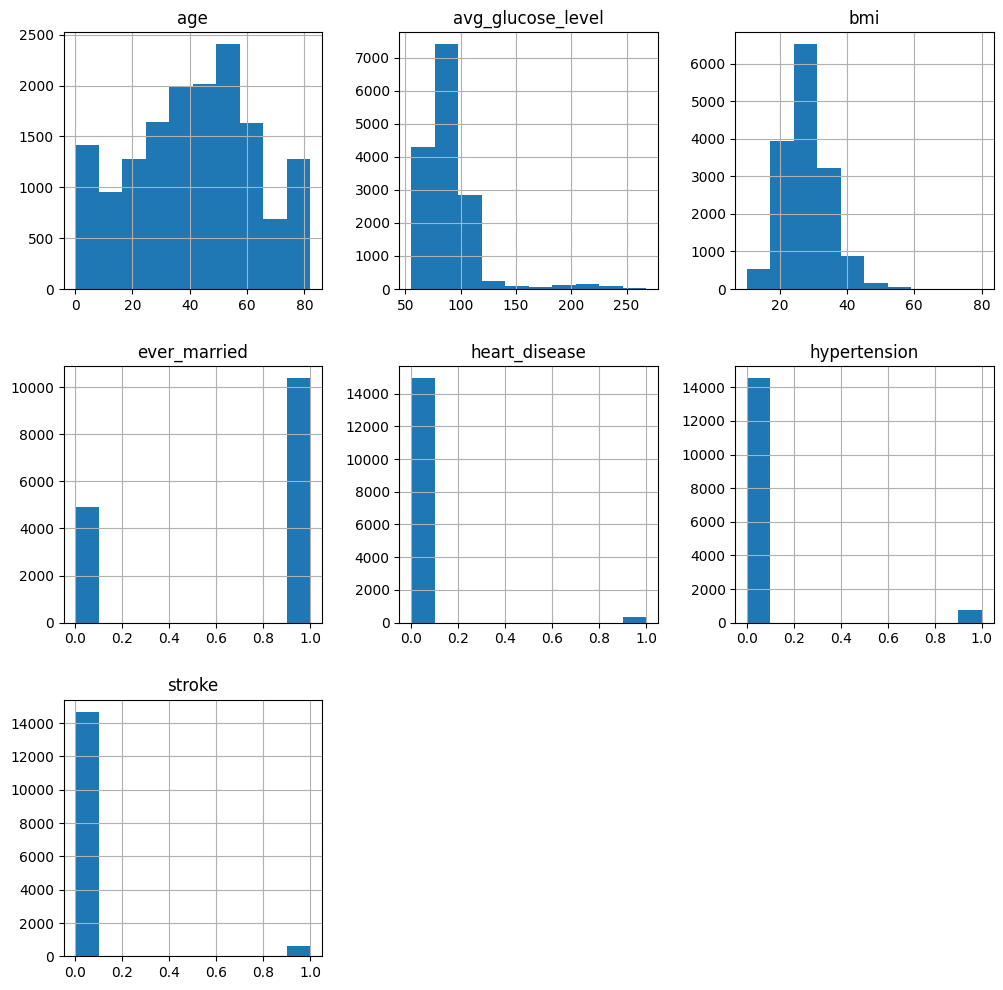

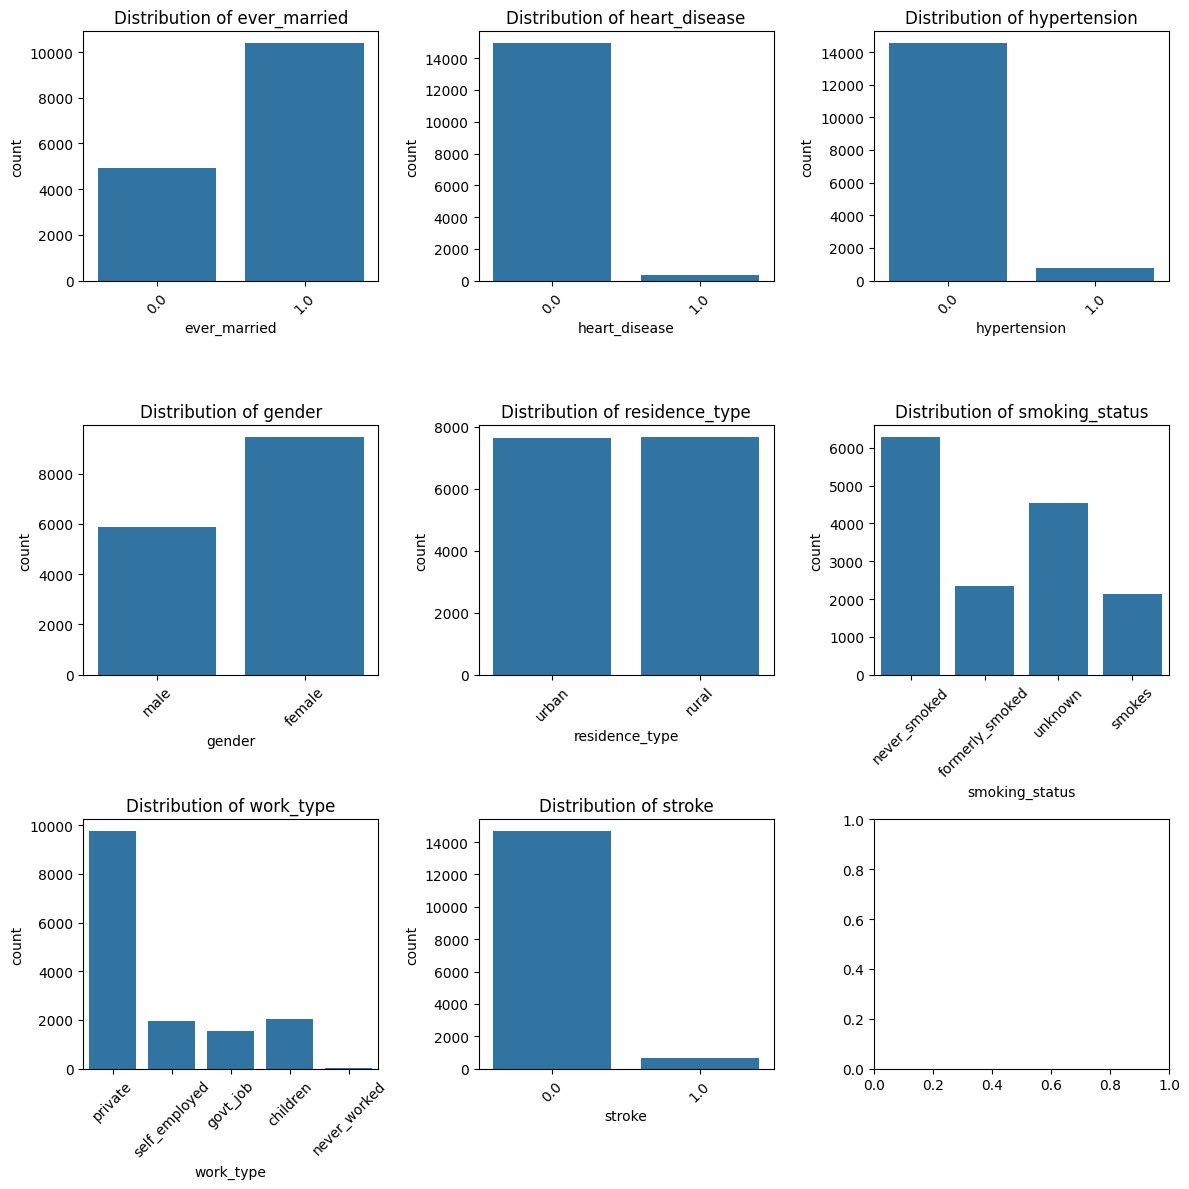

In [7]:
### Histograms for numerical features: df
df.hist(figsize=(12, 12))
plt.show()

### Bar plots for categorical features: df
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Adjust grid size as needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

cols_to_plot = cat_cols
for i, col in enumerate(cols_to_plot):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Data Processing

## To number and onehot (fn)

In [ ]:
#** List of cat
# Loop through object-type columns and print unique values with their counts
map_list = []
for col in df.select_dtypes(include=['object']).columns:
    print(f"Column: {col}")
    unique_values = df[col].value_counts()  # Get unique values and their counts
    for value, count in unique_values.items():
        print(f"    Value: {value}, Count: {count}")
    print(df[col].unique())
    print("-" * 30)  # Separator for better readability
    map_list.append(sorted(df[col].unique().tolist()))

#** Convert list to dict
map_list = [
    ['female', 'male'],
    ['rural', 'urban'],
    ['never_smoked', 'formerly_smoked', 'smokes', 'unknown'],
    ['children', 'govt_job', 'never_worked', 'private', 'self_employed'],
    ['0_children', '13_teens', '18_adults', '45_mid_adults', '60_elderly'],
    ['0_underweight', '19_ideal', '25_overweight', '30_obesity'],
    ['000_low', '090_normal', '160_high', '230_very_high'],
]
map_dict = {}
for s in map_list:
    for x in s:
        map_dict[x] = float(s.index(x))
map_dict, map_list

Column: gender
    Value: female, Count: 9446
    Value: male, Count: 5857
['male' 'female']
------------------------------
Column: residence_type
    Value: rural, Count: 7663
    Value: urban, Count: 7640
['urban' 'rural']
------------------------------
Column: smoking_status
    Value: never_smoked, Count: 6281
    Value: unknown, Count: 4542
    Value: formerly_smoked, Count: 2337
    Value: smokes, Count: 2143
['never_smoked' 'formerly_smoked' 'unknown' 'smokes']
------------------------------
Column: work_type
    Value: private, Count: 9752
    Value: children, Count: 2037
    Value: self_employed, Count: 1939
    Value: govt_job, Count: 1533
    Value: never_worked, Count: 42
['private' 'self_employed' 'govt_job' 'children' 'never_worked']
------------------------------


({'female': 0.0,
  'male': 1.0,
  'rural': 0.0,
  'urban': 1.0,
  'never_smoked': 0.0,
  'formerly_smoked': 1.0,
  'smokes': 2.0,
  'unknown': 3.0,
  'children': 0.0,
  'govt_job': 1.0,
  'never_worked': 2.0,
  'private': 3.0,
  'self_employed': 4.0,
  '0_children': 0.0,
  '13_teens': 1.0,
  '18_adults': 2.0,
  '45_mid_adults': 3.0,
  '60_elderly': 4.0,
  '0_underweight': 0.0,
  '19_ideal': 1.0,
  '25_overweight': 2.0,
  '30_obesity': 3.0,
  '000_low': 0.0,
  '090_normal': 1.0,
  '160_high': 2.0,
  '230_very_high': 3.0},
 [['female', 'male'],
  ['rural', 'urban'],
  ['never_smoked', 'formerly_smoked', 'smokes', 'unknown'],
  ['children', 'govt_job', 'never_worked', 'private', 'self_employed'],
  ['0_children', '13_teens', '18_adults', '45_mid_adults', '60_elderly'],
  ['0_underweight', '19_ideal', '25_overweight', '30_obesity'],
  ['000_low', '090_normal', '160_high', '230_very_high']])

In [ ]:
#** Cat to Num
def to_num(df, map_dict, cols):
    df[cols] = df[cols].replace(map_dict)
    df = reformat(df)
    return df


In [ ]:
#** Add onehot columns
def add_onehot(df, one_cols):
    df = sub_onehot(df, one_cols) #@ sub first add,
    tmp = df[one_cols].copy()
    df = pd.get_dummies(df, columns=one_cols)
    df = df.join(tmp)
    df = reformat(df)
    return df

#** Sub onehot columns
def sub_onehot(df, one_cols):
    # Identify original and one-hot encoded columns
    one_hot_cols = []
    for original_col in one_cols:
        one_hot_cols.extend([col for col in df.columns if col.startswith(original_col + '_')])
    df = df.drop(columns=one_hot_cols)
    df = reformat(df)
    return df


## Handle na & binning (fn)

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#** Fill na by DT, only use dtypes columns not stroke
def fill_na_with_dt(df, target_column, mode='reg'):
    """Fills missing values in the target column using Decision Tree Regressor.

    Args:
        df: The DataFrame with missing values.
        target_column: The name of the column with missing values to fill.

    Returns:
        The DataFrame with filled missing values.
    """

    # Separate rows with and without missing values in the target column
    df_with_missing = df[df[target_column].isnull()]
    df_without_missing = df[df[target_column].notnull()]

    # Features for prediction (exclude the target column)
    # features = df.columns.difference([target_column])
    # Select only float64 columns as features (excluding the target column)
    #!!!
    features = df_without_missing.select_dtypes(include=dtypes).columns.difference([target_column, "stroke"])
    print(features)
    if(len(df_with_missing) == 0):
        print("[+]: Not need to fill")
        return df

    # Train a Decision Tree Regressor on rows without missing values
    X_train = df_without_missing[features]
    y_train = df_without_missing[target_column]

    # Split into train and validation sets (optional)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # X_train = fill_and_onehot(X_train)
    # X_val = fill_and_onehot(X_val)

    # Fit the model
    if(mode == 'reg'):
        model = DecisionTreeRegressor(random_state=42)
    else:
        model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate (optional)
    # y_pred = model.predict(X_val)
    # print(f"Mean squared error: {mean_squared_error(y_val, y_pred)}")

    # Predict missing values using the trained model
    X_pred = df_with_missing[features]
    # X_pred = fill_and_onehot(X_pred)
    predicted_values = model.predict(X_pred)

    # Fill the missing values in the original DataFrame
    df.loc[df[target_column].isnull(), target_column] = predicted_values
    df = reformat(df)
    return df


In [ ]:
#** Binning of numerical variables
def binning(df):
    df['age_cat'] = pd.cut(df['age'],
                            bins = [0, 13, 18, 45, 60, 200],
                            labels = ['0-children', '13-teens', '18-adults','45-mid adults','60-elderly'])
    df['bmi_cat'] = pd.cut(df['bmi'],
                            bins = [0, 19, 25, 30, 10000],
                            labels = ['0-underweight', '19-ideal', '25-overweight', '30-obesity'])
    df['glucose_cat'] = pd.cut(df['avg_glucose_level'],
                            bins = [0, 90, 160, 230, 500],
                            labels = ['000-low', '090-normal', '160-high', '230-very high'])

    df = reformat(df)
    df = to_num(df, map_dict, cols=["age_cat", "bmi_cat", "glucose_cat"])
    df = reformat(df)
    return df


## Process data (!df)

In [13]:
df = to_num(df, map_dict, cols=["gender", "residence_type"])
df = add_onehot(df, one_cols=["work_type"])
df = fill_na_with_dt(df, "bmi", mode="reg")
df = binning(df)
df = df.replace({'unknown': pd.NA})
df.head(10).T
df.info()
df.head(10).T

Index(['age', 'avg_glucose_level', 'ever_married', 'gender', 'heart_disease',
       'hypertension', 'residence_type', 'work_type_children',
       'work_type_govt_job', 'work_type_never_worked', 'work_type_private',
       'work_type_self_employed'],
      dtype='object')
[+]: Not need to fill
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15303 entries, 0 to 15302
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      15303 non-null  float64
 1   age_cat                  15303 non-null  float64
 2   avg_glucose_level        15303 non-null  float64
 3   bmi                      15303 non-null  float64
 4   bmi_cat                  15303 non-null  float64
 5   ever_married             15303 non-null  float64
 6   gender                   15303 non-null  float64
 7   glucose_cat              15303 non-null  float64
 8   heart_disease            15303 non-null  float64
 

,0,1,2,3,4,5,6,7,8,9
age,28.0,33.0,42.0,56.0,24.0,34.0,53.0,78.0,45.0,62.0
age_cat,2.0,2.0,2.0,3.0,2.0,2.0,3.0,4.0,2.0,4.0
avg_glucose_level,79.53,78.44,103.0,64.87,73.36,84.35,88.97,75.32,107.22,62.68
bmi,31.1,23.9,40.3,28.8,28.8,22.2,25.3,24.8,34.1,18.4
bmi_cat,3.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,0.0
ever_married,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
gender,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
glucose_cat,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
hypertension,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df = fill_na_with_dt(df, "smoking_status", mode="cla")
df = sub_onehot(df, one_cols=["work_type"])
df.info()
df.head(10).T

Index(['age', 'age_cat', 'avg_glucose_level', 'bmi', 'bmi_cat', 'ever_married',
       'gender', 'glucose_cat', 'heart_disease', 'hypertension',
       'residence_type', 'work_type_children', 'work_type_govt_job',
       'work_type_never_worked', 'work_type_private',
       'work_type_self_employed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15299 entries, 0 to 15298
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                15299 non-null  float64
 1   age_cat            15299 non-null  float64
 2   avg_glucose_level  15299 non-null  float64
 3   bmi                15299 non-null  float64
 4   bmi_cat            15299 non-null  float64
 5   ever_married       15299 non-null  float64
 6   gender             15299 non-null  float64
 7   glucose_cat        15299 non-null  float64
 8   heart_disease      15299 non-null  float64
 9   hypertension       15299 non-null

,0,1,2,3,4,5,6,7,8,9
age,28.0,33.0,42.0,56.0,24.0,34.0,53.0,78.0,45.0,62.0
age_cat,2.0,2.0,2.0,3.0,2.0,2.0,3.0,4.0,2.0,4.0
avg_glucose_level,79.53,78.44,103.0,64.87,73.36,84.35,88.97,75.32,107.22,62.68
bmi,31.1,23.9,40.3,28.8,28.8,22.2,25.3,24.8,34.1,18.4
bmi_cat,3.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,0.0
ever_married,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
gender,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
glucose_cat,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
hypertension,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Correlation effection

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Select categorical features for correlation analysis
categorical_features = cat_cols
df_categorical = df[categorical_features]

# Initialize an empty correlation matrix
df_corr = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)

total_value = 0.0

# Calculate Chi-Squared statistics and p-values
for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        feature1 = categorical_features[i]
        feature2 = categorical_features[j]

        # Create contingency table
        contingency_table = pd.crosstab(df_categorical[feature1], df_categorical[feature2])

        # Perform Chi-Squared test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Calculate Cramér's V
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2) / (n - 1)
        kcorr = k - ((k - 1)**2) / (n - 1)
        cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

        # Fill the correlation matrix
        df_corr.loc[feature1, feature2] = cramer_v
        df_corr.loc[feature2, feature1] = cramer_v  # Symmetric matrix
        total_value += cramer_v

# Fill diagonal with 1s (correlation with itself)
np.fill_diagonal(df_corr.values, 1)

# Normalize the correlation matrix (as percentages of total Cramér's V)
corr_norm = df_corr.to_numpy()
corr_norm = corr_norm / total_value * 100  # Normalize to percentage
corr_norm = np.round(corr_norm, 1)         # Round to 2 decimal places
df_corr = round(df_corr, 1)

# Create a normalized correlation DataFrame
df_corr_norm = pd.DataFrame(corr_norm, index=df_corr.index, columns=df_corr.columns)

# Display the normalized correlation matrix
stroke_effected = (-df_corr_norm.iloc[-1].copy()).sort_values()  # Negative to flip the sign if necessary
-stroke_effected

,stroke
stroke,13.6
age_cat,4.0
glucose_cat,2.5
hypertension,2.0
heart_disease,1.5
ever_married,1.5
work_type,1.4
bmi_cat,1.1
smoking_status,0.8
gender,0.2


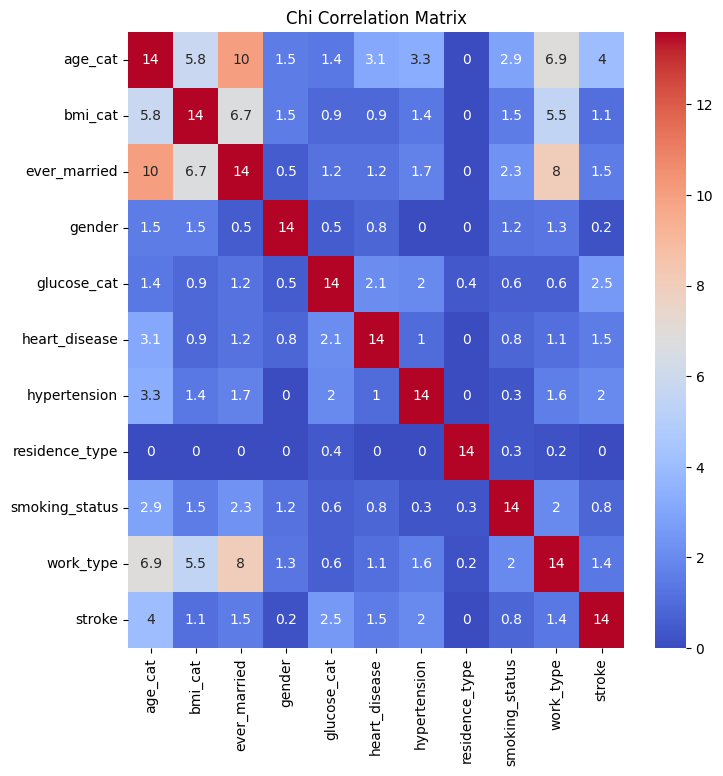

In [16]:
# Correlation matrix for numerical features
plt.figure(figsize=(8, 8))
sns.heatmap(df_corr_norm.T, annot=True, cmap='coolwarm')
plt.title('Chi Correlation Matrix')
plt.show()

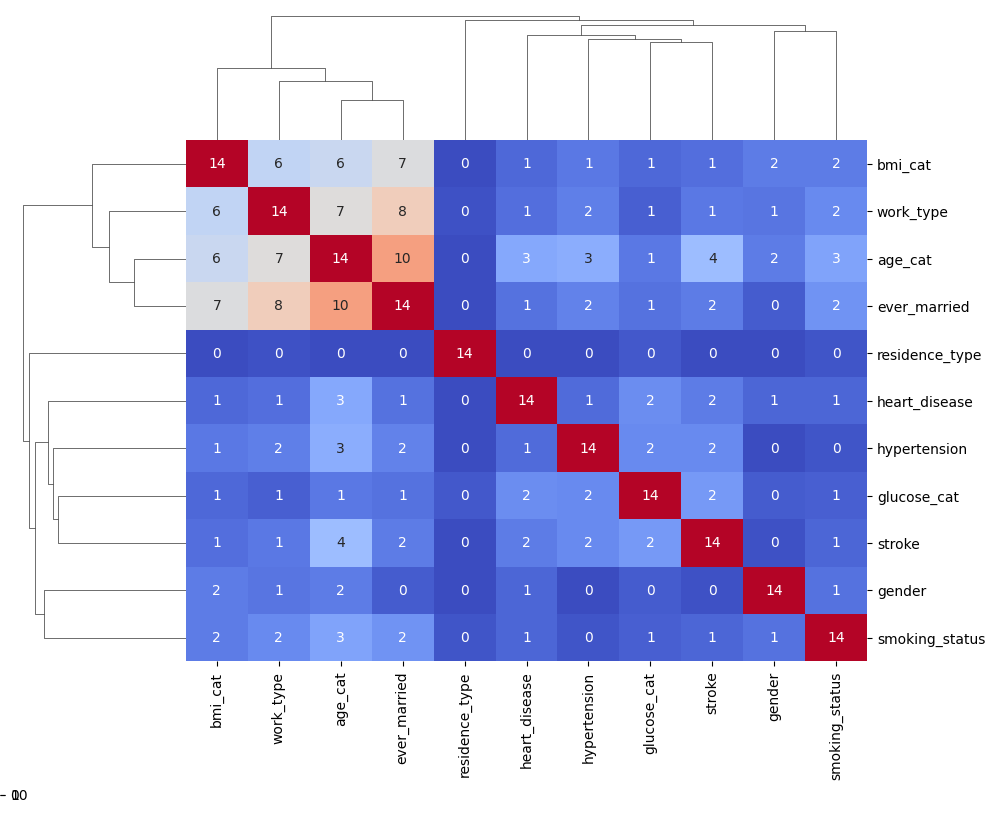

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create clustermap with columns and rows being clustered
sns.clustermap(df_corr_norm, annot=True, fmt='0.0f', cbar_pos=(0, 0, 0, 0),
               cmap='coolwarm', figsize=(10, 8), square=True)
plt.show()

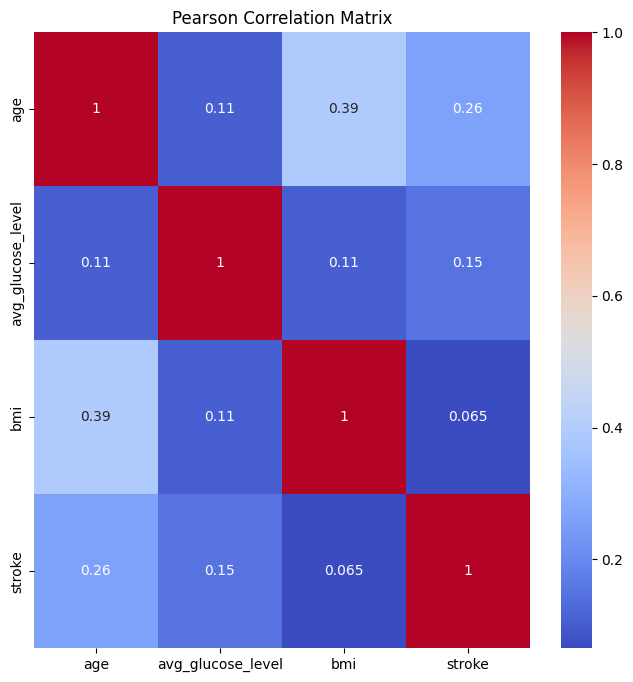

In [18]:
# Correlation matrix for numerical features
plt.figure(figsize=(8, 8))
sns.heatmap(df[num_cols + ["stroke"]].corr(method="pearson"), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

## Probability distribution curves

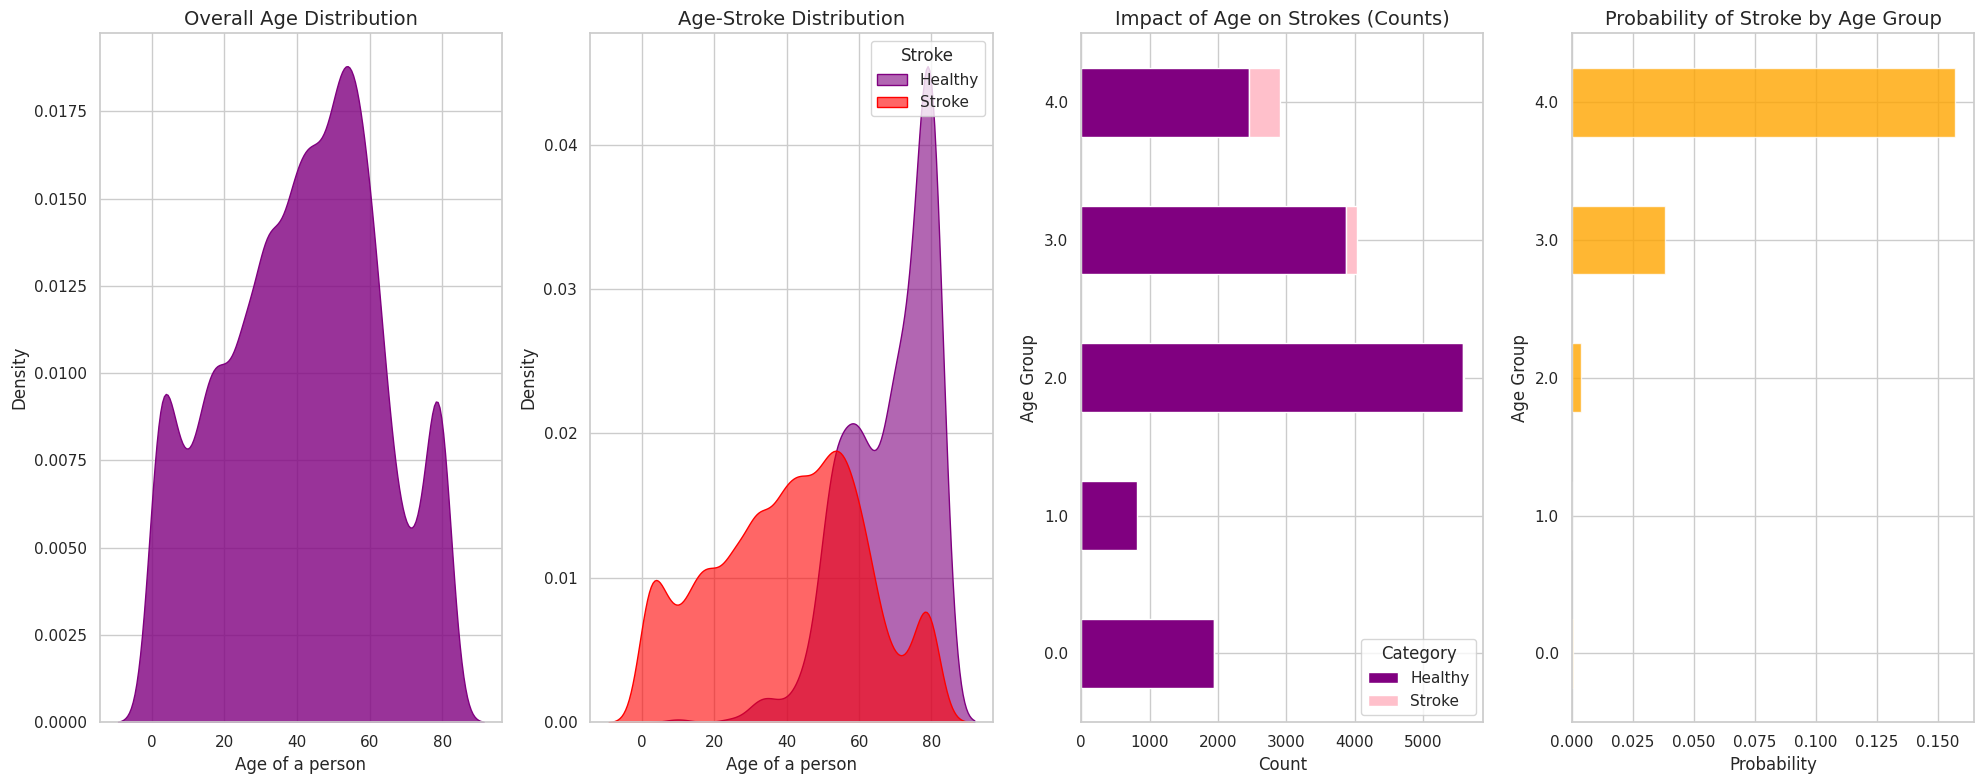

In [19]:
# Calculate the proportion of strokes in each age category
age_group_summary = df.groupby("age_cat")["stroke"].value_counts().unstack(fill_value=0)
age_group_summary.columns = ["Healthy", "Stroke"]
age_group_summary["Stroke Probability"] = (
    age_group_summary["Stroke"] / (age_group_summary["Healthy"] + age_group_summary["Stroke"])
)

# Set the style
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(20, 8))

# 1. Overall Age Distribution
plt.subplot(1, 4, 1)
sns.kdeplot(df["age"], fill=True, color="purple", alpha=0.8)
plt.title("Overall Age Distribution", fontsize=14)
plt.xlabel("Age of a person")
plt.ylabel("Density")

# 2. Age-Stroke Distribution
plt.subplot(1, 4, 2)
sns.kdeplot(data=df, x="age", hue="stroke", fill=True, common_norm=False, alpha=0.6, palette=["red", "purple"])
plt.title("Age-Stroke Distribution", fontsize=14)
plt.xlabel("Age of a person")
plt.legend(title="Stroke", labels=["Healthy", "Stroke"], loc="upper right")

# 3. Impact of Age on Strokes (Counts)
plt.subplot(1, 4, 3)
age_group_summary[["Healthy", "Stroke"]].plot(
    kind="barh", stacked=True, color=["purple", "pink"], ax=plt.gca()
)
plt.title("Impact of Age on Strokes (Counts)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Age Group")
plt.legend(title="Category", labels=["Healthy", "Stroke"], loc="lower right")

# 4. Probability of Stroke by Age Group
plt.subplot(1, 4, 4)
age_group_summary["Stroke Probability"].plot(
    kind="barh", color="orange", ax=plt.gca(), alpha=0.8
)
plt.title("Probability of Stroke by Age Group", fontsize=14)
plt.xlabel("Probability")
plt.ylabel("Age Group")

# Adjust layout and display
plt.tight_layout()
plt.show()

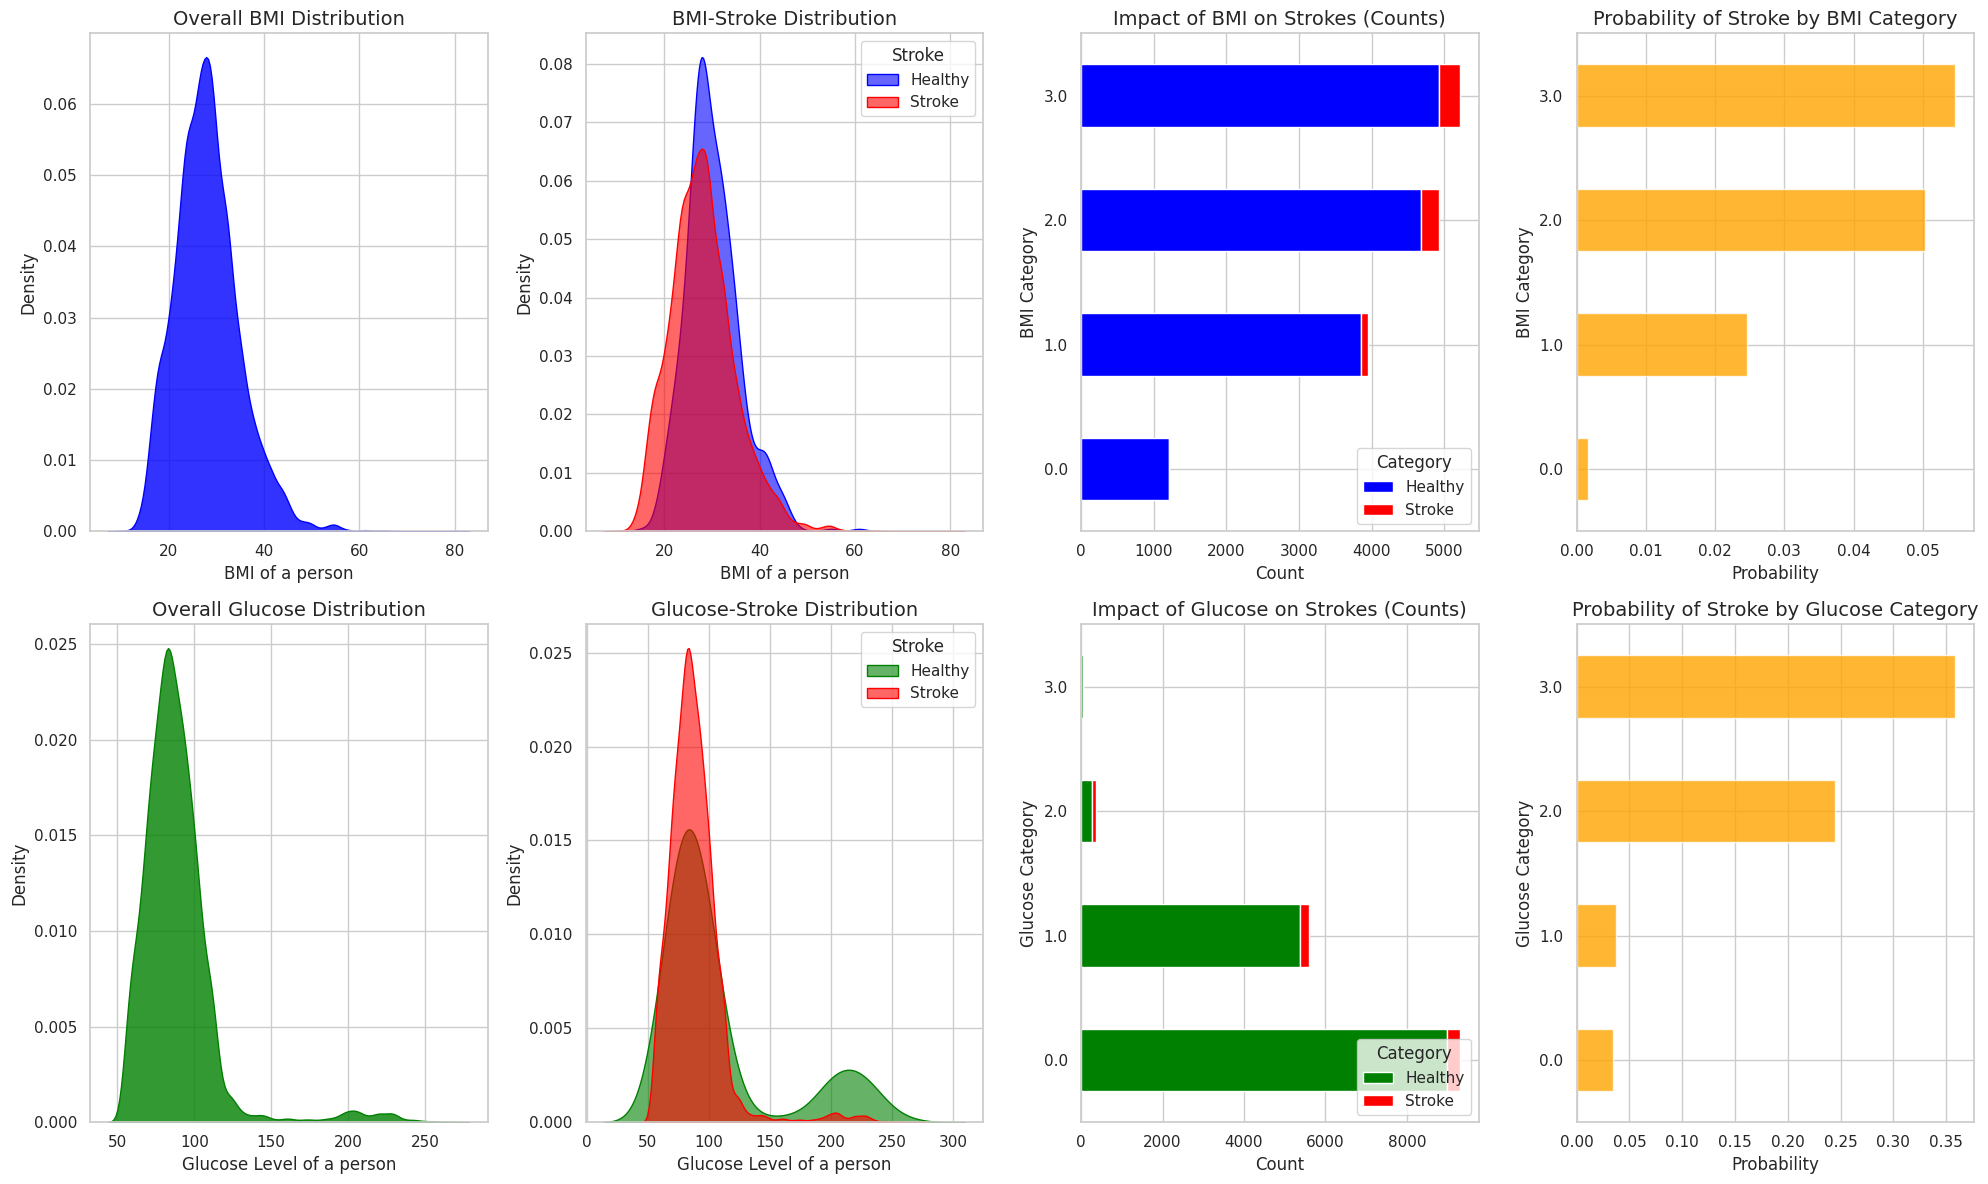

In [20]:
# Calculate stroke probabilities for BMI and Glucose categories
bmi_group_summary = df.groupby("bmi_cat")["stroke"].value_counts().unstack(fill_value=0)
bmi_group_summary.columns = ["Healthy", "Stroke"]
glucose_group_summary = df.groupby("glucose_cat")["stroke"].value_counts().unstack(fill_value=0)
glucose_group_summary.columns = ["Healthy", "Stroke"]

bmi_group_summary["Stroke Probability"] = (
    bmi_group_summary["Stroke"] / (bmi_group_summary["Healthy"] + bmi_group_summary["Stroke"])
)

glucose_group_summary["Stroke Probability"] = (
    glucose_group_summary["Stroke"] / (glucose_group_summary["Healthy"] + glucose_group_summary["Stroke"])
)

# Set the style
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(20, 12))

# ---- BMI Plots ----
# 1. Overall BMI Distribution
plt.subplot(2, 4, 1)
sns.kdeplot(df["bmi"], fill=True, color="blue", alpha=0.8)
plt.title("Overall BMI Distribution", fontsize=14)
plt.xlabel("BMI of a person")
plt.ylabel("Density")

# 2. BMI-Stroke Distribution
plt.subplot(2, 4, 2)
sns.kdeplot(data=df, x="bmi", hue="stroke", fill=True, common_norm=False, alpha=0.6, palette=["red", "blue"])
plt.title("BMI-Stroke Distribution", fontsize=14)
plt.xlabel("BMI of a person")
plt.legend(title="Stroke", labels=["Healthy", "Stroke"], loc="upper right")

# 3. Impact of BMI on Strokes (Counts)
plt.subplot(2, 4, 3)
bmi_group_summary[["Healthy", "Stroke"]].plot(
    kind="barh", stacked=True, color=["blue", "red"], ax=plt.gca()
)
plt.title("Impact of BMI on Strokes (Counts)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("BMI Category")
plt.legend(title="Category", labels=["Healthy", "Stroke"], loc="lower right")

# 4. Probability of Stroke by BMI Category
plt.subplot(2, 4, 4)
bmi_group_summary["Stroke Probability"].plot(
    kind="barh", color="orange", ax=plt.gca(), alpha=0.8
)
plt.title("Probability of Stroke by BMI Category", fontsize=14)
plt.xlabel("Probability")
plt.ylabel("BMI Category")

# ---- Glucose Level Plots ----
# 5. Overall Glucose Distribution
plt.subplot(2, 4, 5)
sns.kdeplot(df["avg_glucose_level"], fill=True, color="green", alpha=0.8)
plt.title("Overall Glucose Distribution", fontsize=14)
plt.xlabel("Glucose Level of a person")
plt.ylabel("Density")

# 6. Glucose-Stroke Distribution
plt.subplot(2, 4, 6)
sns.kdeplot(data=df, x="avg_glucose_level", hue="stroke", fill=True, common_norm=False, alpha=0.6, palette=["red", "green"])
plt.title("Glucose-Stroke Distribution", fontsize=14)
plt.xlabel("Glucose Level of a person")
plt.legend(title="Stroke", labels=["Healthy", "Stroke"], loc="upper right")

# 7. Impact of Glucose on Strokes (Counts)
plt.subplot(2, 4, 7)
glucose_group_summary[["Healthy", "Stroke"]].plot(
    kind="barh", stacked=True, color=["green", "red"], ax=plt.gca()
)
plt.title("Impact of Glucose on Strokes (Counts)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Glucose Category")
plt.legend(title="Category", labels=["Healthy", "Stroke"], loc="lower right")

# 8. Probability of Stroke by Glucose Category
plt.subplot(2, 4, 8)
glucose_group_summary["Stroke Probability"].plot(
    kind="barh", color="orange", ax=plt.gca(), alpha=0.8
)
plt.title("Probability of Stroke by Glucose Category", fontsize=14)
plt.xlabel("Probability")
plt.ylabel("Glucose Category")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [21]:
# Get the column names (features)
stroke_effected_columns = stroke_effected.index
# Convert to a list (optional)
stroke_effected_columns_list = stroke_effected_columns.tolist()
# Print the column names
stroke_effected_columns_list

['stroke',
 'age_cat',
 'glucose_cat',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'bmi_cat',
 'smoking_status',
 'gender',
 'residence_type']

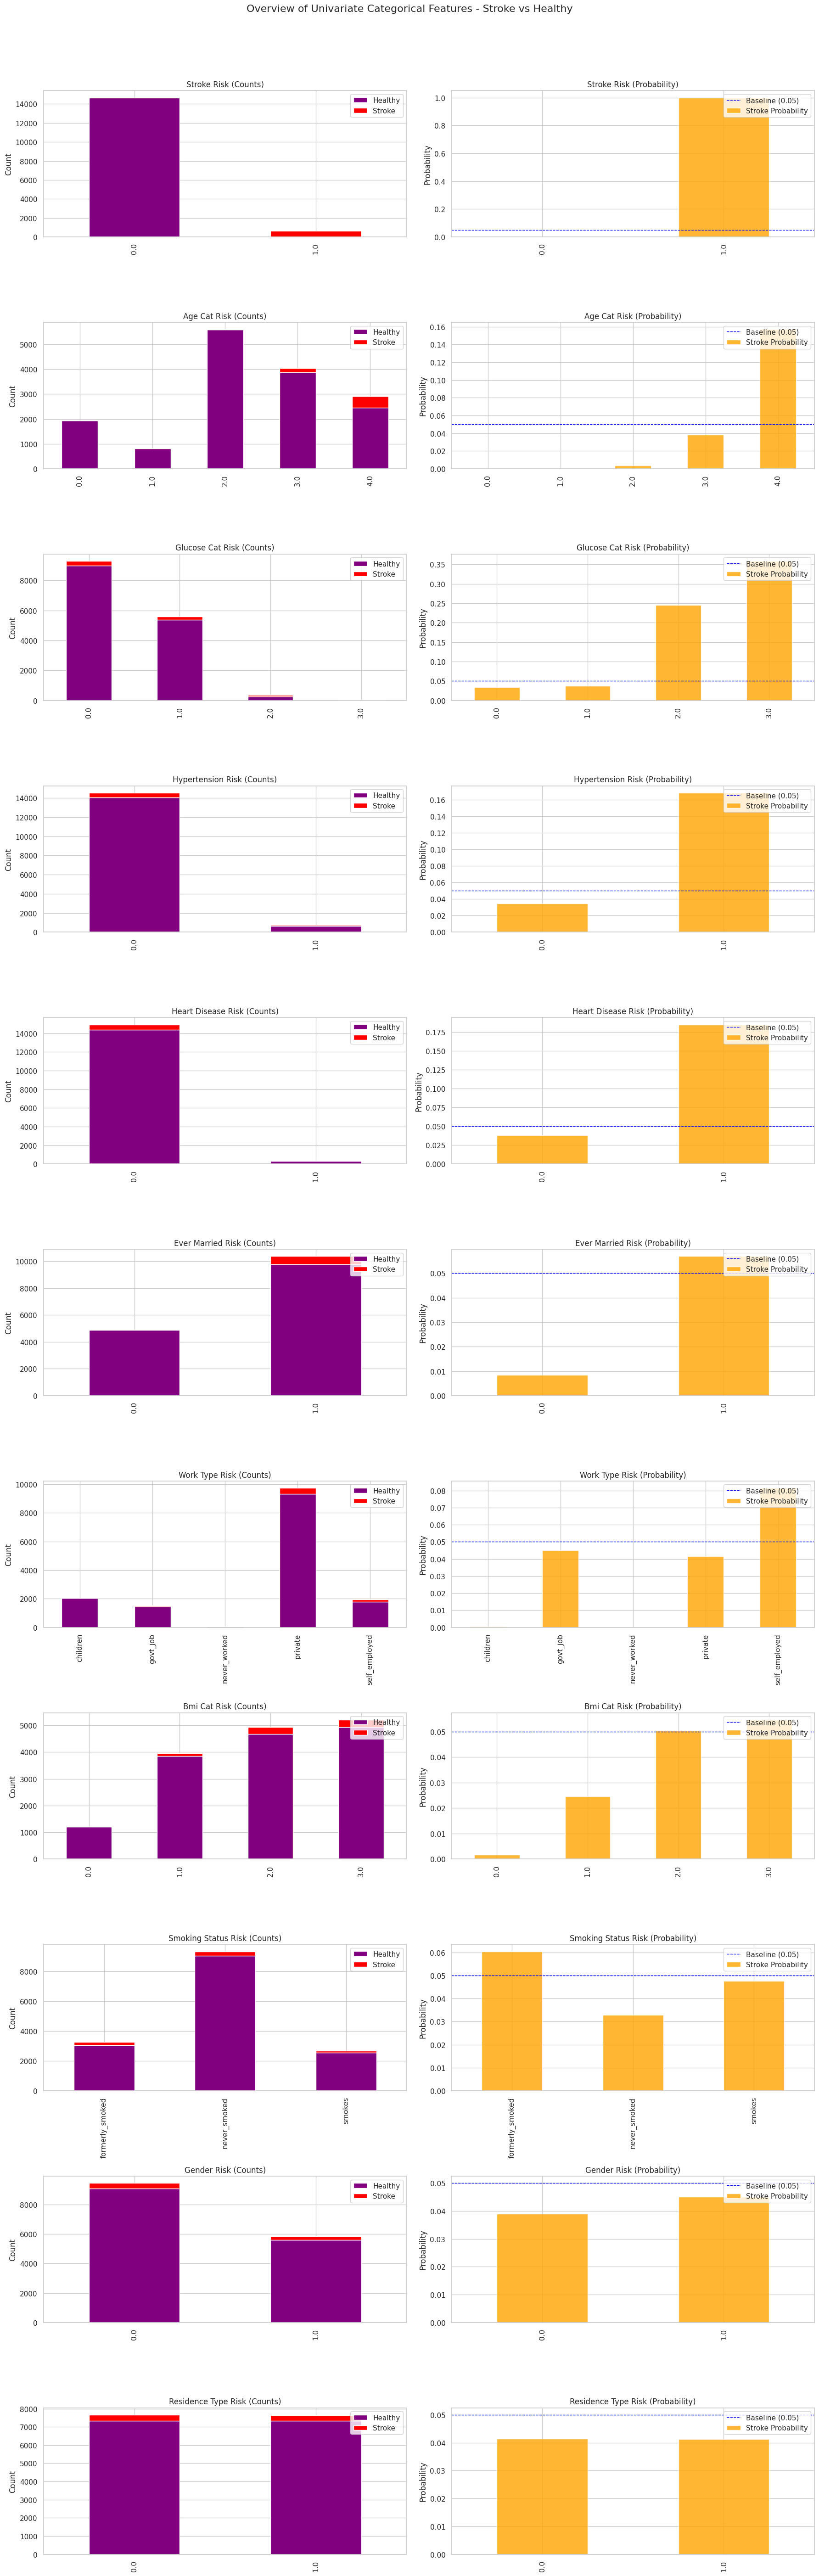

In [22]:
# Function to create stacked bar plots with stroke probability and a baseline
def plot_categorical_features_with_prob(feature, ax1, ax2):
    # Aggregate the data
    feature_summary = df.groupby([feature, "stroke"]).size().unstack(fill_value=0)
    feature_summary.columns = ["Healthy", "Stroke"]

    # Stroke Probability Calculation
    feature_summary["Stroke Probability"] = (
        feature_summary["Stroke"] / (feature_summary["Healthy"] + feature_summary["Stroke"])
    )

    # Plot stacked bar chart
    feature_summary[["Healthy", "Stroke"]].plot(
        kind="bar", stacked=True, color=["purple", "red"], ax=ax1
    )
    ax1.set_title(f"{feature.replace('_', ' ').title()} Risk (Counts)", fontsize=12)
    ax1.set_xlabel("")
    ax1.set_ylabel("Count")
    ax1.legend(["Healthy", "Stroke"], loc="upper right")

    # Plot stroke probability
    feature_summary["Stroke Probability"].plot(
        kind="bar", color="orange", ax=ax2, alpha=0.8
    )
    ax2.set_title(f"{feature.replace('_', ' ').title()} Risk (Probability)", fontsize=12)
    ax2.set_xlabel("")
    ax2.set_ylabel("Probability")

    # Add a baseline at 0.05
    ax2.axhline(y=0.05, color="blue", linestyle="--", linewidth=1, label="Baseline (0.05)")
    ax2.legend(loc="upper right")

# Set up the figure for subplots (two rows per feature)
feats = stroke_effected_columns_list
num_features = len(feats)
fig, axes = plt.subplots(num_features, 2, figsize=(18, 5 * num_features))
axes = axes.reshape(num_features, 2)  # Reshape for pairing

# Plot each feature
for i, feature in enumerate(feats):
    plot_categorical_features_with_prob(feature, axes[i, 0], axes[i, 1])

# Adjust layout and titles
plt.suptitle(
    "Overview of Univariate Categorical Features - Stroke vs Healthy", fontsize=16, y=1.02
)
plt.tight_layout()
plt.show()

# Behavior

In [23]:
new_df1 = add_onehot(df.copy(), ["work_type", "smoking_status"])
new_df1 = new_df1.drop(columns=["work_type", "smoking_status"])
new_df1.info()
new_df1.head(10).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15299 entries, 0 to 15298
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             15299 non-null  float64
 1   age_cat                         15299 non-null  float64
 2   avg_glucose_level               15299 non-null  float64
 3   bmi                             15299 non-null  float64
 4   bmi_cat                         15299 non-null  float64
 5   ever_married                    15299 non-null  float64
 6   gender                          15299 non-null  float64
 7   glucose_cat                     15299 non-null  float64
 8   heart_disease                   15299 non-null  float64
 9   hypertension                    15299 non-null  float64
 10  residence_type                  15299 non-null  float64
 11  smoking_status_formerly_smoked  15299 non-null  float64
 12  smoking_status_never_smoked     

,0,1,2,3,4,5,6,7,8,9
age,28.00,33.00,42.0,56.00,24.00,34.00,53.00,78.00,45.00,62.00
age_cat,2.00,2.00,2.0,3.00,2.00,2.00,3.00,4.00,2.00,4.00
avg_glucose_level,79.53,78.44,103.0,64.87,73.36,84.35,88.97,75.32,107.22,62.68
bmi,31.10,23.90,40.3,28.80,28.80,22.20,25.30,24.80,34.10,18.40
bmi_cat,3.00,1.00,3.0,2.00,2.00,1.00,2.00,1.00,3.00,0.00
ever_married,1.00,1.00,1.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00
gender,1.00,1.00,0.0,1.00,0.00,0.00,0.00,1.00,0.00,0.00
glucose_cat,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00
heart_disease,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.00
hypertension,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Explained Variance Ratio:  (20,)
Cumulative Variance:  (20,)


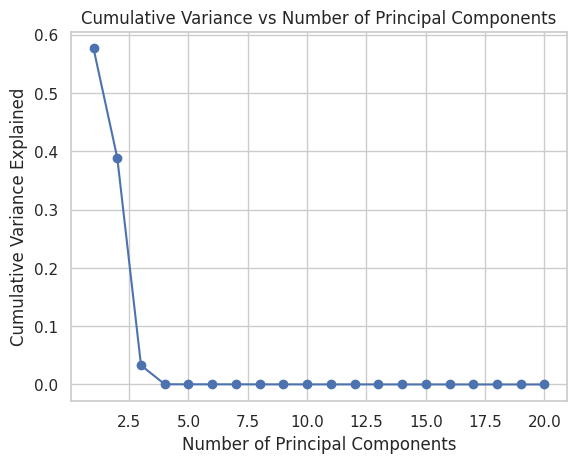

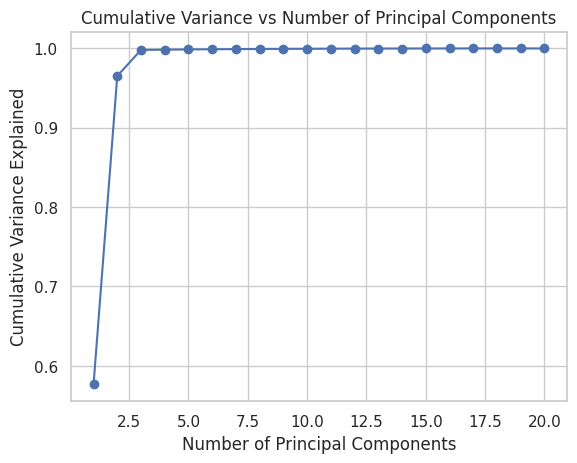

Explained Variance Ratio:  (19,)
Cumulative Variance:  (19,)


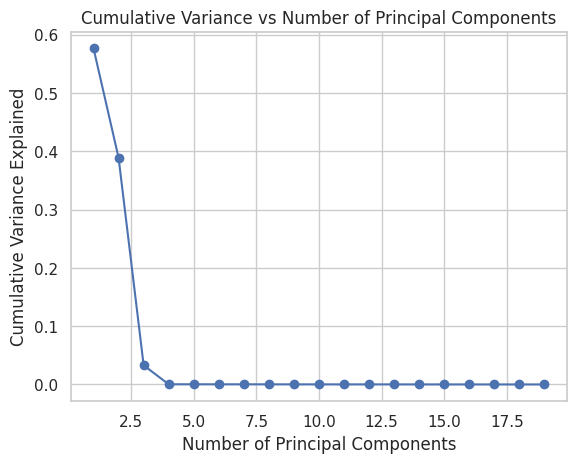

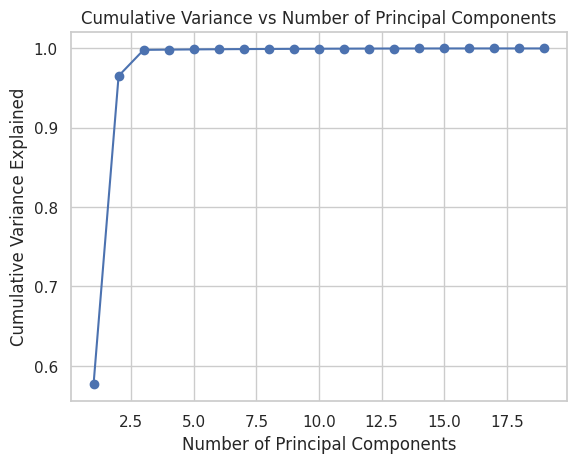

In [24]:
from sklearn.decomposition import PCA
import numpy as np

def get_explained_variance(df):
    # Assuming data is a list of vectors (a 2D array)
    data = df.copy()
    # Handle NaN values - Imputation with mean
    data = data.fillna(data.mean()) # Replace NaN with the mean of each column
    # Alternative: Remove rows with NaN
    # data = data.dropna()

    # Perform PCA
    pca = PCA()
    pca.fit(data)

    # Explained variance by each principal component
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("Explained Variance Ratio: ", explained_variance.shape)
    print("Cumulative Variance: ", cumulative_variance.shape)

    import matplotlib.pyplot as plt

    # Plot cumulative variance
    plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
    # plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance vs Number of Principal Components')
    plt.grid(True)
    plt.show()

    # plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance vs Number of Principal Components')
    plt.grid(True)
    plt.show()

get_explained_variance(new_df1)
get_explained_variance(new_df1.drop(columns="stroke"))

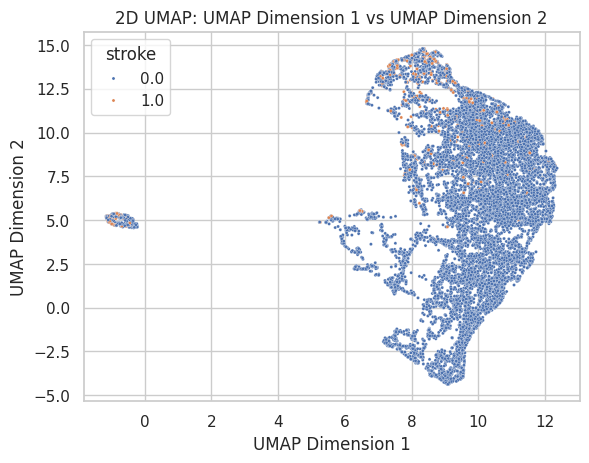

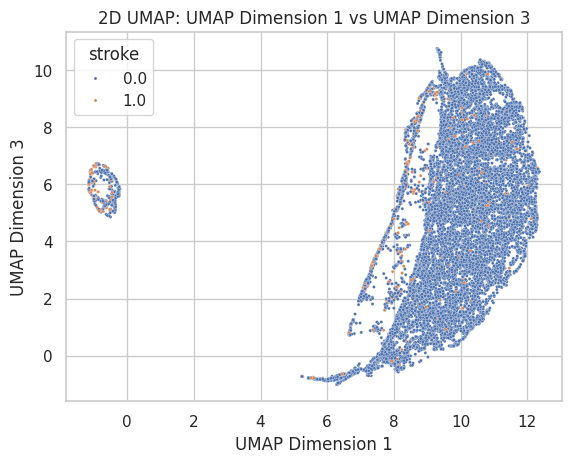

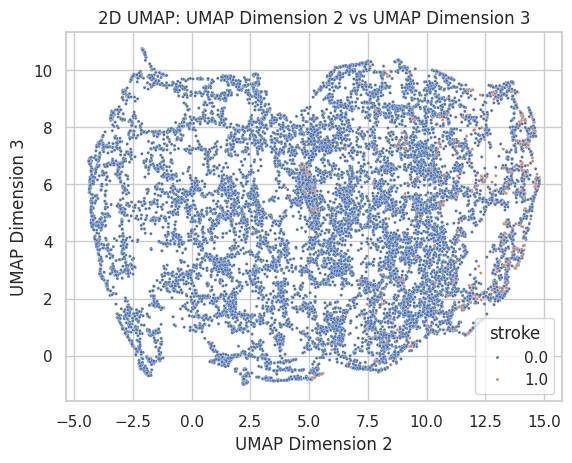

In [25]:
import umap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def draw_umap_2d_pairs_sns(data, target_column='stroke'):
    """Draws 2D scatter plots for each pair of dimensions in the 3D UMAP embedding using Seaborn."""

    # Convert data to DataFrame if not already
    data = pd.DataFrame(data)

    # Handle NaN values - Imputation with mean
    data = data.fillna(data.mean())

    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Apply UMAP dimensionality reduction (3 dimensions)
    reducer = umap.UMAP(n_components=3)
    embedding = reducer.fit_transform(X)

    # Create a DataFrame for plotting with Seaborn
    plot_df = pd.DataFrame(embedding, columns=['UMAP Dimension 1', 'UMAP Dimension 2', 'UMAP Dimension 3'])
    plot_df[target_column] = y

    # Define dimension pairs for plotting
    dimension_pairs = [
        ('UMAP Dimension 1', 'UMAP Dimension 2'),
        ('UMAP Dimension 1', 'UMAP Dimension 3'),
        ('UMAP Dimension 2', 'UMAP Dimension 3')
    ]

    # Create and show scatter plots for each pair
    for x_dim, y_dim in dimension_pairs:
        plt.figure()  # Create a new figure for each plot
        sns.scatterplot(x=x_dim, y=y_dim, hue=target_column, data=plot_df, s=5)
        plt.title(f'2D UMAP: {x_dim} vs {y_dim}')
        plt.show()

draw_umap_2d_pairs_sns(new_df1)

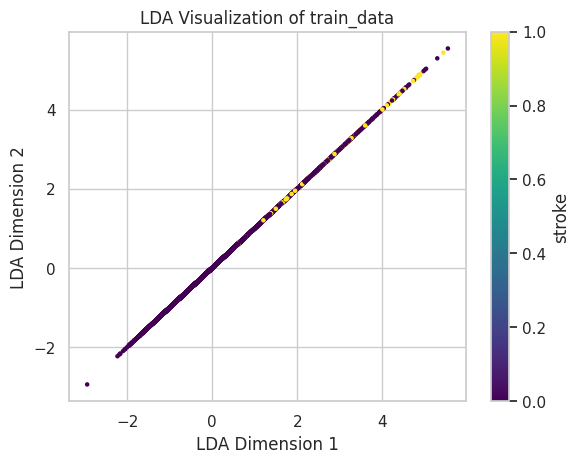

In [26]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def draw_lda(data, target_column='stroke'):
    """Draws an LDA visualization of the input data, color-coded by target class."""

    # Convert data to DataFrame if not already
    data = pd.DataFrame(data)

    # Handle NaN values - Imputation with mean
    data = data.fillna(data.mean())

    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Apply LDA dimensionality reduction
    lda = LinearDiscriminantAnalysis(n_components=1)  # Reduce to 2 dimensions for visualization
    embedding = lda.fit_transform(X, y)

    # Plot the embedding, color-coded by target class
    scatter = plt.scatter(embedding[:, 0], embedding[:, 0], c=y, cmap='viridis', s=5)
    plt.title('LDA Visualization of train_data')
    plt.xlabel('LDA Dimension 1')
    plt.ylabel('LDA Dimension 2')

    # Add a colorbar and set its label (title)
    cbar = plt.colorbar(scatter)  # Get the colorbar object
    cbar.set_label(target_column)  # Set the label (title) of the colorbar

    plt.show()

draw_lda(new_df1)

stroke
0.0    632
1.0    632
Name: count, dtype: int64
Explained Variance Ratio:  (20,)
Cumulative Variance:  (20,)


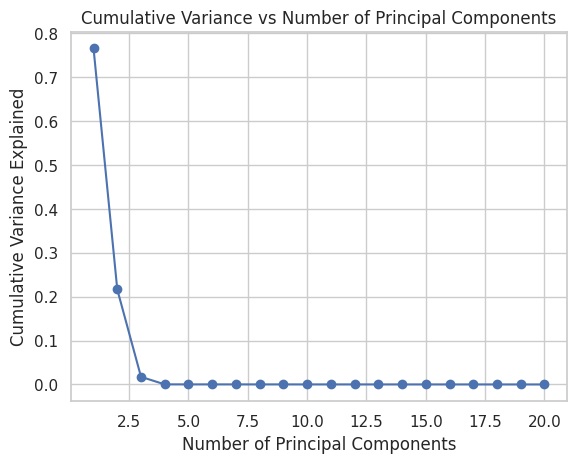

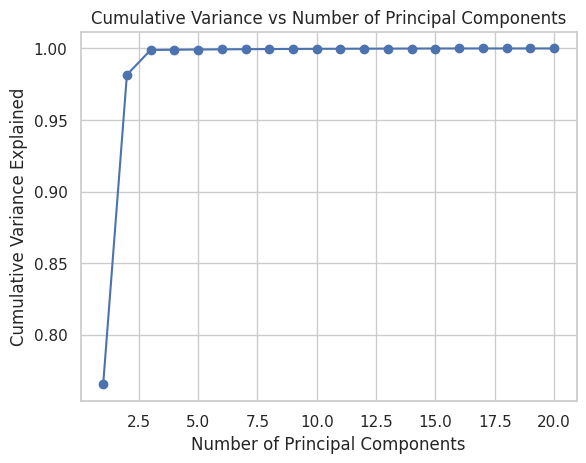

Explained Variance Ratio:  (19,)
Cumulative Variance:  (19,)


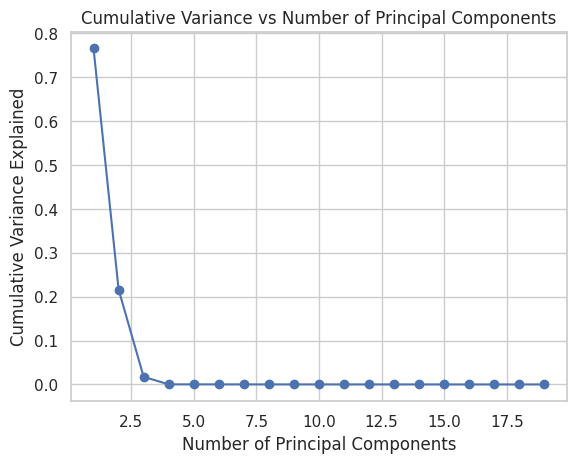

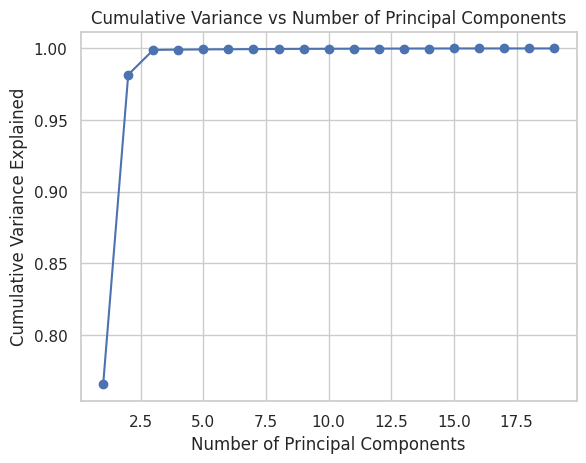

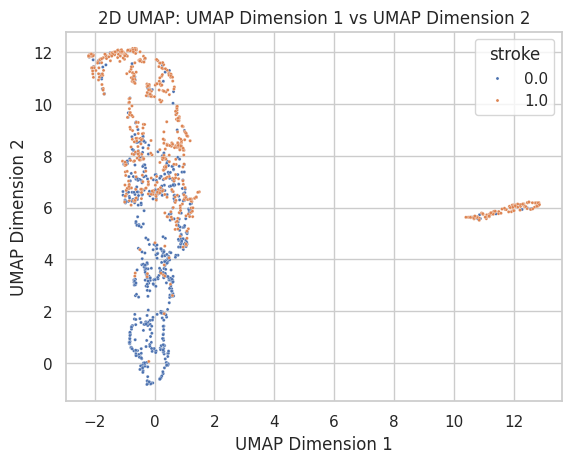

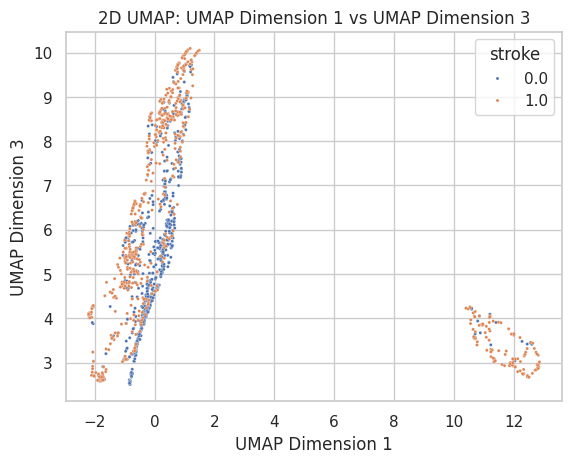

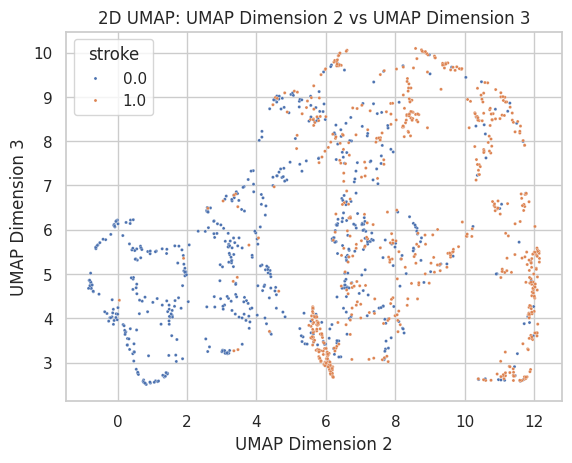

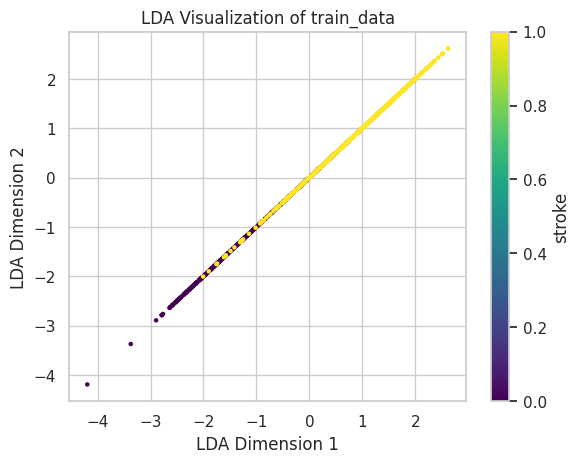

In [27]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Define the individual sampling steps
random_state = 42
undersampler = RandomUnderSampler(random_state=random_state)
oversampler = SMOTE(random_state=random_state)
# Create the pipeline
pipeline = Pipeline([
    ('undersampling', undersampler),
    ('oversampling', oversampler)
])

X, y = pipeline.fit_resample(new_df1.drop(columns="stroke"), new_df1['stroke'])
print(y.value_counts())
# for col in X.columns:
    # X[col] = StandardScaler().fit_transform(X[[col]])
new_df = pd.concat([X, y], axis=1)
get_explained_variance(new_df)
get_explained_variance(new_df.drop(columns="stroke"))
draw_umap_2d_pairs_sns(new_df)
draw_lda(new_df)

stroke
0.0    632
1.0    632
Name: count, dtype: int64
Explained Variance Ratio:  (20,)
Cumulative Variance:  (20,)


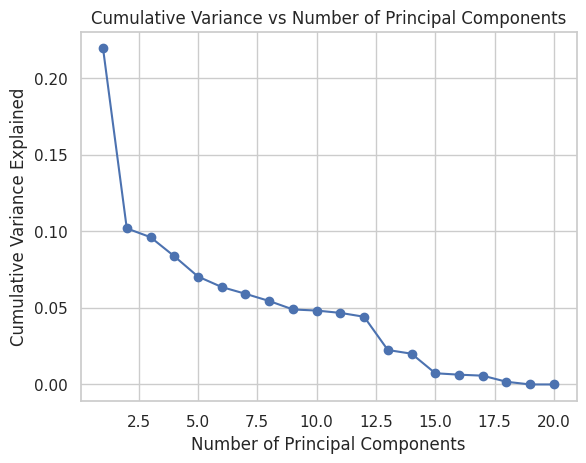

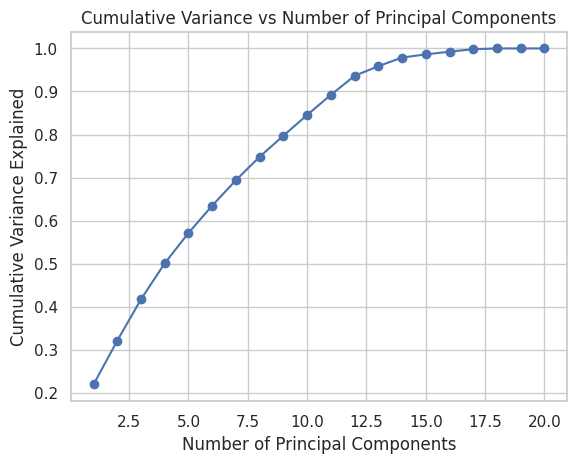

Explained Variance Ratio:  (19,)
Cumulative Variance:  (19,)


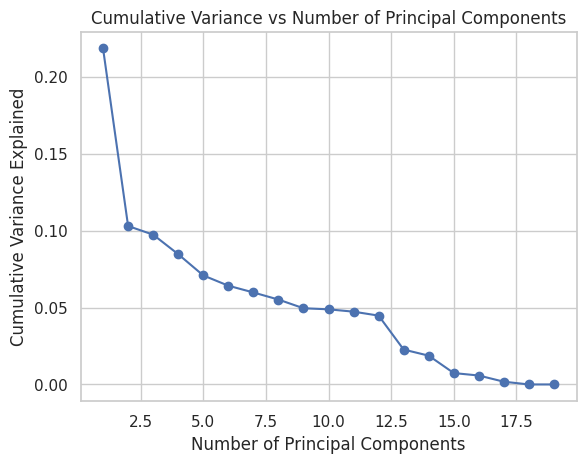

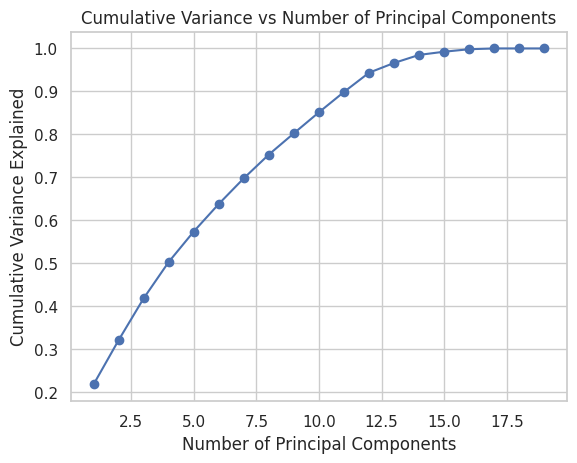

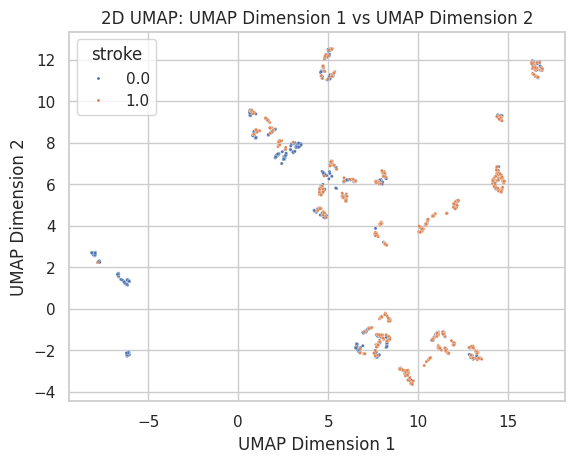

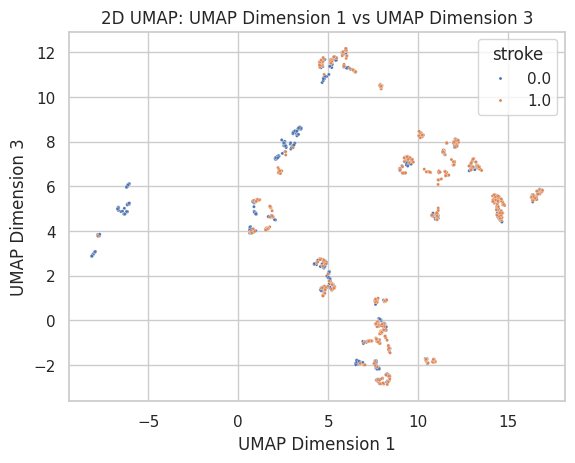

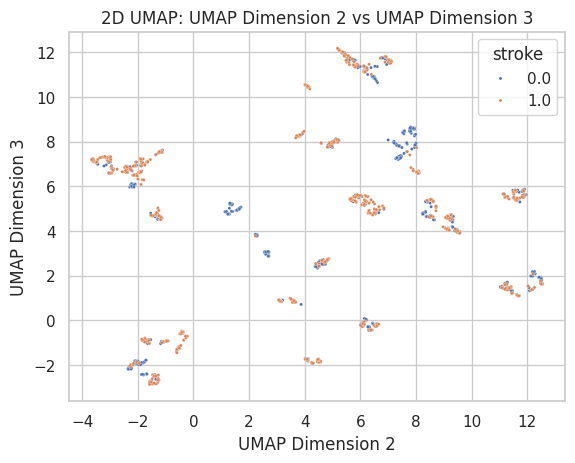

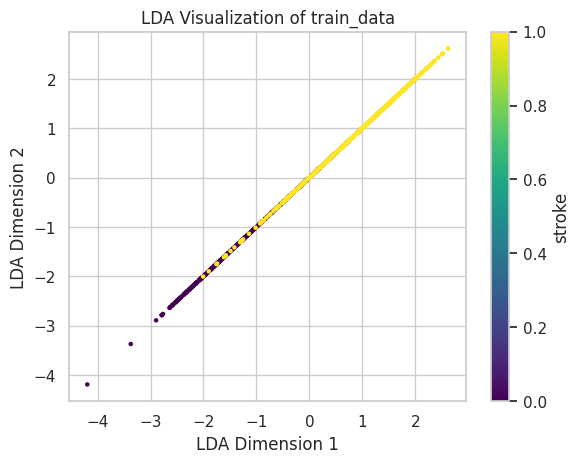

In [28]:
X, y = pipeline.fit_resample(new_df1.drop(columns="stroke"), new_df1['stroke'])
print(y.value_counts())
for col in X.columns:
    X[col] = StandardScaler().fit_transform(X[[col]])
new_df = pd.concat([X, y], axis=1)
get_explained_variance(new_df)
get_explained_variance(new_df.drop(columns="stroke"))
draw_umap_2d_pairs_sns(new_df)
draw_lda(new_df)